<a href="https://colab.research.google.com/github/Tlon9/CS114/blob/main/Project/Toxic_Comment_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install vncorenlp

In [ ]:
!pip install py_vncorenlp

In [ ]:
!pip install unidecode

In [ ]:
!pip install transformers

In [ ]:
!pip install autokeras

## Library Setup

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer

phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [ ]:
import numpy as np
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud

import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [ ]:
#Set up vncorelp to use in this assignment
import logging
from vncorenlp import VnCoreNLP
import py_vncorenlp

In [ ]:
#!cp '/content/drive/MyDrive/CS114 /Final_Project/abbreviations.py' '/content/abbreviations.py'

!cp '/content/drive/MyDrive/CS114/Final_Project/abbreviations.py' '/content/abbreviations.py'

In [ ]:
!ls

abbreviations.py  drive  sample_data


In [ ]:
from abbreviations import Abb

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#py_vncorenlp.download_model(save_dir='/content/drive/MyDrive/Sarcasm/vnNLP')
py_vncorenlp.download_model(save_dir='/content/')

# Load VnCoreNLP from the local working folder that contains both `VnCoreNLP-1.2.jar` and `models`
#model = py_vncorenlp.VnCoreNLP(save_dir='/content/drive/MyDrive/Sarcasm/vnNLP')
model_vncorenlp = py_vncorenlp.VnCoreNLP(save_dir='/content/')

#Load data

In [ ]:
#link_data = '/content/drive/MyDrive/CS114 /Final_Project/Dataset.csv'
link_data = '/content/drive/MyDrive/CS114/Final_Project/Dataset.csv'
data = pd.read_csv(link_data)
data.head ()

,Id,Label,Comment
0,1,0,"Slayder, GAM cần anh."
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!"
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p..."
3,4,0,Mê cái cách anh này nhảy E
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công


##Xóa mẫu chưa gán nhãn

In [ ]:
index = data[data['Label'].isnull() == True].index
data.drop(index, inplace= True)

In [ ]:
data.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10691 entries, 0 to 10690
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       10691 non-null  int64 
 1   Label    10691 non-null  int64 
 2   Comment  10691 non-null  object
dtypes: int64(2), object(1)
memory usage: 250.7+ KB


##Kiểm tra nhãn

In [ ]:
values = set()
data['Label'].apply(lambda x: values.add(x))
print(values)

{0, 1, 2}


# Preprocessing - Tiền xử lý dữ liệu

In [ ]:
data.duplicated().sum()

0

In [ ]:
#Đưa các từ lowercase
data['text'] = data['Comment'].str.lower()
#Loại bỏ dấu câu
character = ['\'','.',',','-',':','"','!','~','?',']','*']
character = set(character)
data['text'] = data['text'].apply(lambda x: ''.join([char for char in x if char not in character]))
data.head()

,Id,Label,Comment,text
0,1,0,"Slayder, GAM cần anh.",slayder gam cần anh
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè k chỉ nhảy qua tường sờ ty lè nhảy ph...
3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy e
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc mừng\ngam đã có kỳ chuyển nhượng thành công


##Giải nghĩa từ viết tắt

In [ ]:
abb = Abb()
data['text'] = data['text'].apply(lambda x: ''.join([abb.rep(char)+' ' for char in x.split()]))
data.head()

,Id,Label,Comment,text
0,1,0,"Slayder, GAM cần anh.",slayder gam cần anh
1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè không chỉ nhảy qua tường sờ ty lè nhả...
3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy em
4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc mừng gam đã có kỳ chuyển nhượng thành công


##Word segmentation

In [ ]:
#Thực hiện Word Segmentation bằng toolkit VNCoreLP
data['text'] = data['text'].apply(lambda x: " ".join(word for word in model_vncorenlp.word_segment(x)))

In [ ]:
data.reset_index(inplace = True)
data

,index,Id,Label,Comment,text
0,0,1,0,"Slayder, GAM cần anh.",slayder gam cần_anh
1,1,2,0,"Dạ mỗi khi Gam cần, em luôn sẵn sèng!!",dạ mỗi khi gam cần em luôn sẵn sèng
2,2,3,0,"sờ ty lè k chỉ nhảy qua tường, sờ ty lè nhảy p...",sờ ty lè không_chỉ nhảy qua tường sờ ty lè nhả...
3,3,4,0,Mê cái cách anh này nhảy E,mê cái cách anh này nhảy em
4,4,5,0,Chúc mừng\nGam đã có kỳ chuyển nhượng thành công,chúc_mừng gam đã có kỳ chuyển_nhượng thành_công
...,...,...,...,...,...
10686,10686,10687,2,Người ta bảo người hay nói đạo lí thường sống ...,người ta bảo người hay nói đạo_lí thường sống ...
10687,10687,10688,2,Riêng tư sao đéo có hari má,riêng_tư sao đéo có hari má
10688,10688,10689,2,Nói đạo lý thường sống như iồn,nói đạo_lý thường sống như iồn
10689,10689,10690,2,Lũ ngu ngục tụi m bỏ tiền ủng hộ phim nó giờ n...,lũ ngu ngục tụi mày bỏ tiền ủng_hộ phim nó giờ...


##Bỏ Stopword

In [ ]:
data_train = []

#Loại bỏ các stopword
link_vn_stopword = '/content/drive/MyDrive/CS114/Final_Project/vietnamese-stopwords.txt'
stop_words = set(line.strip() for line in open(link_vn_stopword))
for sentence in data['text']:
    sen_new = ""
    sen_temp = sentence.split()
    #print(sen_temp)
    for word in sen_temp:
        #print(word,'.')
        if (word not in stop_words):
            sen_new += word + " "
        #print()
    data_train.append(sen_new)

print ("Headlines after Preprocessing")
for i in range (0,20):
  print (f"{i+1}/",data_train[i])

Headlines after Preprocessing
1/ slayder gam cần_anh 
2/ gam sẵn sèng 
3/ sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy phát team 
4/ mê nhảy 
5/ chúc_mừng gam kỳ chuyển_nhượng thành_công 
6/ mê nhảy 
7/ chuẩn thoát pressing luônnn 
8/ ok chúc sơn thành công đường tiếp giờ thì hóng ad mới 
9/ gam đầu_tư đi cửa sân_bay 
10/ trận best gánh 
11/ thằng hankay out hài vãi lồn đôn huấn_luyện_viên tạm vị_trí analyst gam tuyển huấn_luyện_viên chả ảnh_hưởng 
12/ msi xong thank you vị_trí sty1e 
13/ đem shogun đem taki 2 đánh kết_hợp 
14/ thầy sty1e lck hướng_dẫn thằng peyz thằng guma đánh zeri 2 thằng đánh ngu 
15/ dũng phạm se gam giúp thoát pressing 
16/ nghi_thức hiến tế bắt_đầu 
17/ ôi cảm_động hoá_thân thành fan gam khứa hơi anti gam một_chút 
18/ kick ác nhường chỗ tướng_quân 
19/ tao đợi thank you kati mãi 
20/ mong sty1e 


In [ ]:
data['Comment'] = data_train
data

,index,Id,Label,Comment,text
0,0,1,0,slayder gam cần_anh,slayder gam cần_anh
1,1,2,0,gam sẵn sèng,dạ mỗi khi gam cần em luôn sẵn sèng
2,2,3,0,sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy ph...,sờ ty lè không_chỉ nhảy qua tường sờ ty lè nhả...
3,3,4,0,mê nhảy,mê cái cách anh này nhảy em
4,4,5,0,chúc_mừng gam kỳ chuyển_nhượng thành_công,chúc_mừng gam đã có kỳ chuyển_nhượng thành_công
...,...,...,...,...,...
10686,10686,10687,2,ta bảo đạo_lí sống lol,người ta bảo người hay nói đạo_lí thường sống ...
10687,10687,10688,2,riêng_tư đéo hari má,riêng_tư sao đéo có hari má
10688,10688,10689,2,đạo_lý sống iồn,nói đạo_lý thường sống như iồn
10689,10689,10690,2,lũ ngu ngục tụi mày tiền ủng_hộ phim đối_xử tụ...,lũ ngu ngục tụi mày bỏ tiền ủng_hộ phim nó giờ...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


# Data Visualization

### 1. Phân bố nhãn

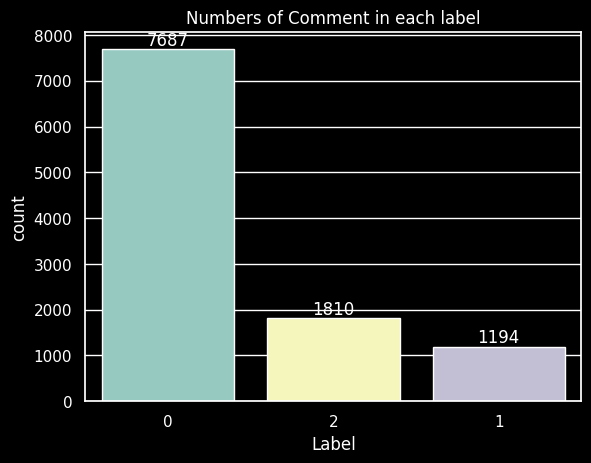

In [ ]:
label_name = ['0','1','2']
plt.style.use('dark_background')
ax = sns.countplot(x ="Label", data = data)
plt.xticks (ticks = data['Label'].unique(), labels=label_name)
ax.bar_label (ax.containers[0])
plt.title ("Numbers of Comment in each label")
plt.show ()

In [ ]:
#df = data[data['Label']==0]['Comment'].apply(len)
print ("Thống kê về độ dài của comment")
print("Độ dài trung bình của comment:",data['Comment'].apply(len).mean())

print ("Phân bố giá trị của comment: Min =",data['Comment'].apply(len).min(),", Max =",data['Comment'].apply(len).max())

print('-' * 55)
print ("Label 0")
print ("Miền giá trị độ dài: Min =",data[data['Label']==0]['Comment'].apply(len).min(),", Max =",data[data['Label']==0]['Comment'].apply(len).max())
print ("Độ dài trung bình của comment:",data[data['Label']==0]['Comment'].apply(len).mean())

print('-' * 55)
print ("Label 1")
print ("Miền giá trị độ dài: Min =",data[data['Label']==1]['Comment'].apply(len).min(),", Max =",data[data['Label']==0]['Comment'].apply(len).max())
print ("Độ dài trung bình của comment:",data[data['Label']==1]['Comment'].apply(len).mean())

print('-' * 55)
print ("Label 2")
print ("Miền giá trị độ dài: Min =",data[data['Label']==2]['Comment'].apply(len).min(),", Max =",data[data['Label']==0]['Comment'].apply(len).max())
print ("Độ dài trung bình của comment:",data[data['Label']==2]['Comment'].apply(len).mean())

Thống kê về độ dài của comment
Độ dài trung bình của comment: 34.82322471275193
Phân bố giá trị của comment: Min = 2 , Max = 238
-------------------------------------------------------
Label 0
Miền giá trị độ dài: Min = 2 , Max = 213
Độ dài trung bình của comment: 32.1265756302521
-------------------------------------------------------
Label 1
Miền giá trị độ dài: Min = 3 , Max = 213
Độ dài trung bình của comment: 37.22996130458817
-------------------------------------------------------
Label 2
Miền giá trị độ dài: Min = 3 , Max = 213
Độ dài trung bình của comment: 48.38893545683152


In [ ]:
data = data[data['Comment'].apply(len) > 0]
data.reset_index(inplace = True)
data

,level_0,index,Id,Label,Comment,text
0,0,0,1,0,slayder gam cần_anh,slayder gam cần_anh
1,1,1,2,0,gam sẵn sèng,dạ mỗi khi gam cần em luôn sẵn sèng
2,2,2,3,0,sờ ty lè không_chỉ nhảy tường sờ ty lè nhảy ph...,sờ ty lè không_chỉ nhảy qua tường sờ ty lè nhả...
3,3,3,4,0,mê nhảy,mê cái cách anh này nhảy em
4,4,4,5,0,chúc_mừng gam kỳ chuyển_nhượng thành_công,chúc_mừng gam đã có kỳ chuyển_nhượng thành_công
...,...,...,...,...,...,...
10613,10686,10686,10687,2,ta bảo đạo_lí sống lol,người ta bảo người hay nói đạo_lí thường sống ...
10614,10687,10687,10688,2,riêng_tư đéo hari má,riêng_tư sao đéo có hari má
10615,10688,10688,10689,2,đạo_lý sống iồn,nói đạo_lý thường sống như iồn
10616,10689,10689,10690,2,lũ ngu ngục tụi mày tiền ủng_hộ phim đối_xử tụ...,lũ ngu ngục tụi mày bỏ tiền ủng_hộ phim nó giờ...


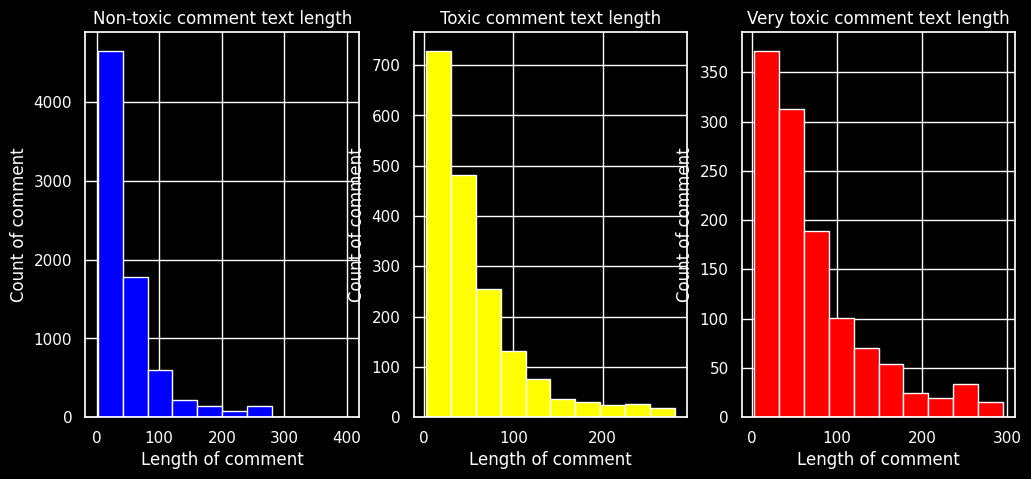

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,5))
plt.style.use('dark_background')
text_len=data[data['Label']==0]['text'].apply(len)
ax1.hist(text_len,color='blue')
ax1.set_xlabel('Length of comment')
ax1.set_ylabel('Count of comment')
ax1.set_title('Non-toxic comment text length')

text_len=data[data['Label']==1]['text'].apply(len)
ax2.hist(text_len,color='yellow')
ax2.set_xlabel('Length of comment')
ax2.set_ylabel('Count of comment')
ax2.set_title('Toxic comment text length')

text_len=data[data['Label']==2]['text'].apply(len)
ax3.hist(text_len,color='red')
ax3.set_xlabel('Length of comment')
ax3.set_ylabel('Count of comment')
ax3.set_title('Very toxic comment text length')

plt.show()

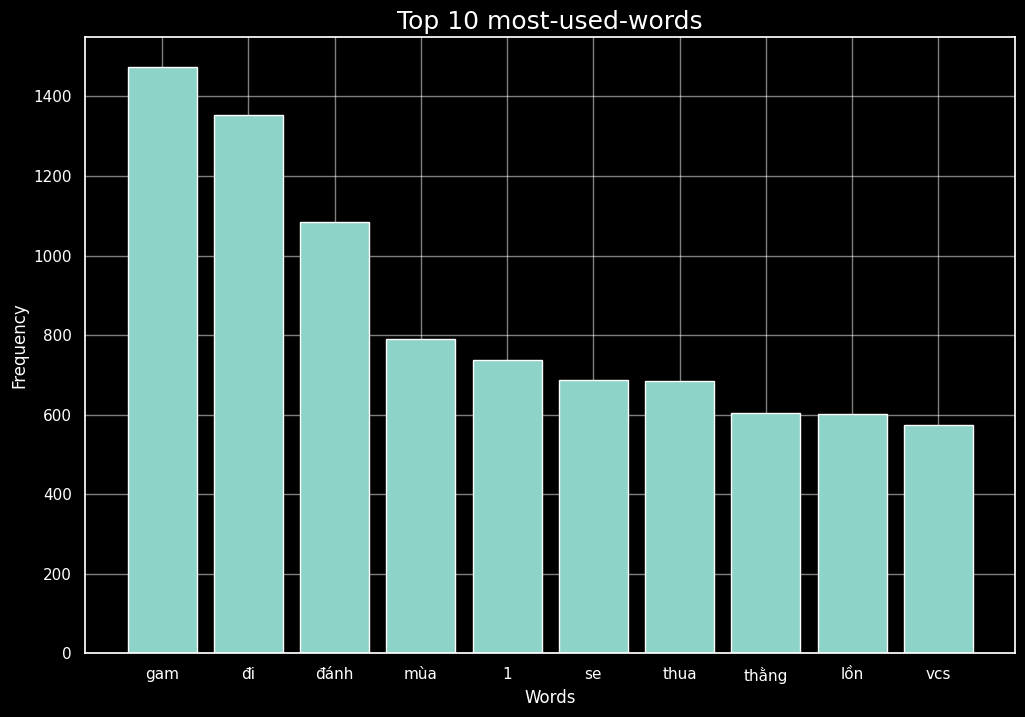

In [ ]:
words = []

for text in data_train:
    words.extend(text.split())
word_count = collections.Counter(words)
top_words = dict(word_count.most_common(10))
plt.style.use('dark_background')
plt.figure(figsize = (12, 8))
plt.bar(range(len(top_words)), list(top_words.values()), align='center')
plt.xticks(range(len(top_words)), list(top_words.keys()))
plt.grid(alpha = 0.5)
plt.title('Top 10 most-used-words', fontsize = 18)
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.show()

Text(0.5, 12.44444444444443, 'Token Count')

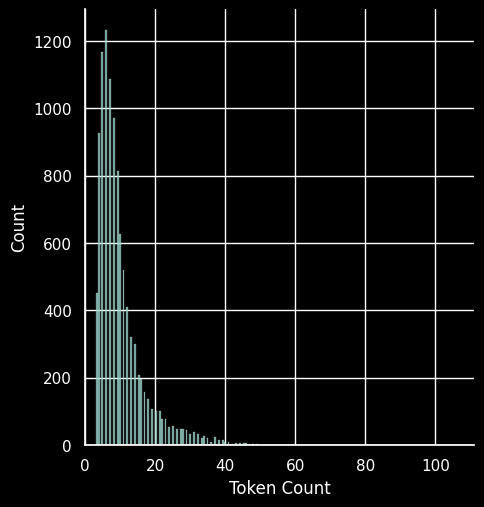

In [ ]:
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in data['Comment']]
token_lens = [len(text) for text in encoded_text]
sns.displot(token_lens)
plt.xlim([0,max(token_lens)])
plt.xlabel('Token Count')

##Spliting Data - Thực hiện phân chia tập dữ liệu thành tập Train và tập Test

- Tỉ lệ giữa tập Train và Test là 80:20

In [ ]:
X = np.array(data['Comment'])
Y = np.array(data['Label'])

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size = 0.20, random_state = 0, shuffle = True)

In [ ]:
print ("Thống kê số lượng dữ liệu của tập Train và tập Test")

print ("Tập train")
print ("Kích thước tập Train:",xtrain.shape)
for i in range (len(label_name)):
    print(label_name[i],":",np.count_nonzero(ytrain==i))
print('-' * 55)
print ("Tập test")
print ("Kích thước tập Test:",xtest.shape)
for i in range(len(label_name)):
    print(label_name[i],":",np.count_nonzero(ytest==i))

Thống kê số lượng dữ liệu của tập Train và tập Test
Tập train
Kích thước tập Train: (8494,)
0 : 6110
1 : 1441
2 : 943
-------------------------------------------------------
Tập test
Kích thước tập Test: (2124,)
0 : 1506
1 : 368
2 : 250


#Chọn 1 trong 2 để chuyển text về vector

In [ ]:
cv = CountVectorizer()

xtrain_transform = cv.fit_transform(xtrain)
xtest_transform = cv.transform (xtest)

In [ ]:
tf = TfidfVectorizer()
xtrain_transform = tf.fit_transform(xtrain)
xtest_transform = tf.transform (xtest)

# Training


Nhóm thực hiện xây dựng 5 model để thực hiện phân lớp cho bài tập này tương ứng với dùng phương pháp trích xuất đặc trưng Count Vectorizer gồm:
1. Support Vector Classifier (SVC)*
2. Random Forest*
3. Decision Tree*
4. Logistic Regression*
5. Multinomial Naive Bayes*

*Các tham số được dùng mặc định cho từng mô hình

In [ ]:
clf = svm.SVC()
clf.fit(xtrain_transform ,ytrain)

tree = DecisionTreeClassifier()
tree.fit(xtrain_transform,ytrain)

rgs = LogisticRegression()
rgs.fit(xtrain_transform,ytrain)

mnb = MultinomialNB()
mnb.fit (xtrain_transform,ytrain)

rdf=RandomForestClassifier()
rdf.fit(xtrain_transform,ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier()

#Predict && Eval


Kết quả phân lớp của 5 mô hình dựa trên Classfication Report

In [ ]:
pred_svm = clf.predict(xtest_transform)
pred_tree = tree.predict(xtest_transform)
pred_rdf = rdf.predict(xtest_transform)
pred_rgs = rgs.predict(xtest_transform)
pred_mnb = mnb.predict(xtest_transform)

print(f"Accuracy SVC: {accuracy_score(ytest,pred_svm)}")
print(classification_report(ytest,pred_svm))

print('-' * 55)

print(f"Accuracy Decision Tree: {accuracy_score(ytest,pred_tree)}")
print(classification_report(ytest,pred_tree))

print('-' * 55)

print(f"Accuracy Random Forest: {accuracy_score(ytest,pred_rdf)}")
print(classification_report(ytest,pred_rdf))

print('-' * 55)

print(f"Accuracy Logistic Regression: {accuracy_score(ytest,pred_rgs)}")
print(classification_report(ytest,pred_rgs))

print('-' * 55)

print(f"Accuracy Multinomial Navie Bayes: {accuracy_score(ytest,pred_mnb)}")
print(classification_report(ytest,pred_mnb))

Accuracy SVC: 0.8290960451977402
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      1506
           1       0.75      0.46      0.57       368
           2       0.87      0.42      0.56       250

    accuracy                           0.83      2124
   macro avg       0.82      0.62      0.68      2124
weighted avg       0.83      0.83      0.81      2124

-------------------------------------------------------
Accuracy Decision Tree: 0.8305084745762712
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1506
           1       0.60      0.62      0.61       368
           2       0.67      0.60      0.63       250

    accuracy                           0.83      2124
   macro avg       0.73      0.71      0.72      2124
weighted avg       0.83      0.83      0.83      2124

-------------------------------------------------------
Accuracy Random Forest: 0.8549905838041432
       

In [ ]:
print(f"Accuracy: {accuracy_score(ytest,pred_mnb)}")
print ("Precision:",precision_score(ytest,pred_mnb,average='macro'))
print ("Recall:",recall_score(ytest,pred_mnb,average='macro'))
print ("F1:",f1_score(ytest,pred_mnb,average='macro'))

Accuracy SVM: 0.7627118644067796
Precision: 0.7742184858110618
Recall: 0.45857117424023713
F1: 0.4903942173574354


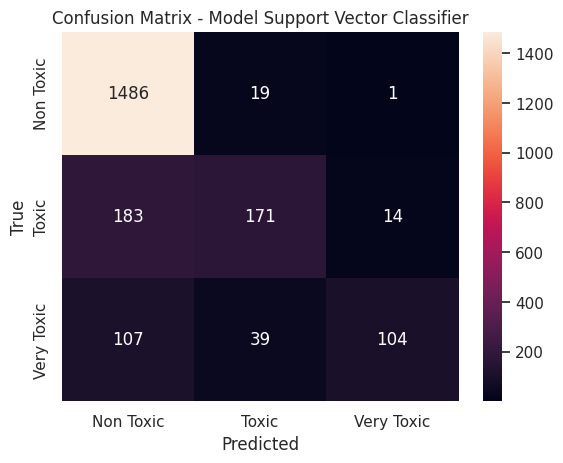

In [ ]:
cf = confusion_matrix (ytest,pred_svm)
label_name = ['Non Toxic','Toxic','Very Toxic']
sns.set(font_scale=1.)
sns.heatmap(cf, annot=True,xticklabels=label_name,yticklabels=label_name, annot_kws={"size": 12},fmt='d')
plt.title ("Confusion Matrix - Model Support Vector Classifier",fontsize=12)
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('True',fontsize=12)
plt.show()

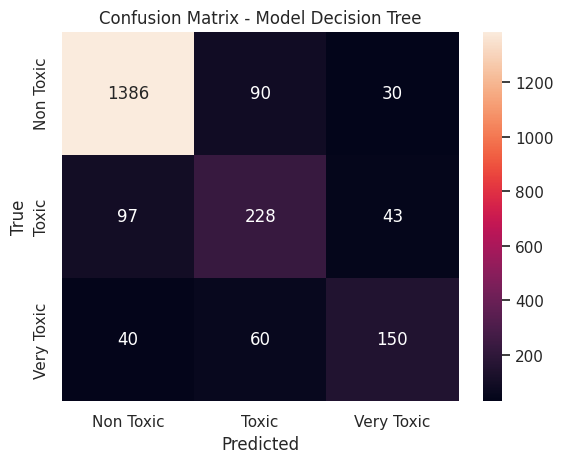

In [ ]:
cf = confusion_matrix (ytest,pred_tree)

sns.set(font_scale=1.)
sns.heatmap(cf, annot=True,xticklabels=label_name,yticklabels=label_name, annot_kws={"size": 12},fmt='d')
plt.title ("Confusion Matrix - Model Decision Tree",fontsize=12)
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('True',fontsize=12)
plt.show()

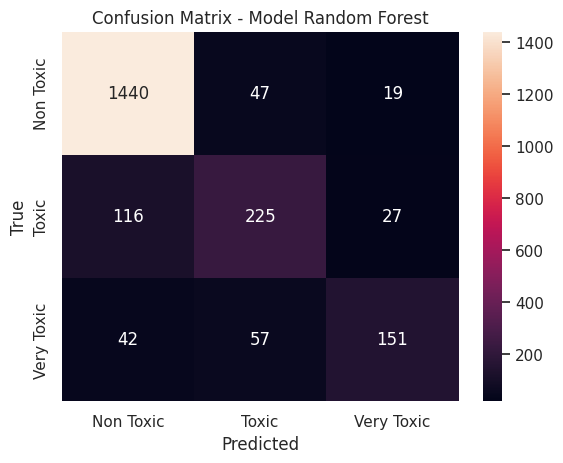

In [ ]:
cf = confusion_matrix (ytest,pred_rdf)

sns.set(font_scale=1.)
sns.heatmap(cf, annot=True,xticklabels=label_name,yticklabels=label_name, annot_kws={"size": 12},fmt='d')
plt.title ("Confusion Matrix - Model Random Forest",fontsize=12)
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('True',fontsize=12)
plt.show()

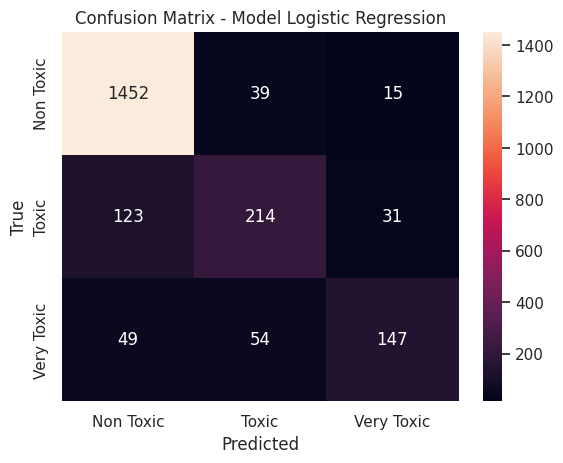

In [ ]:
cf = confusion_matrix (ytest,pred_rgs)
label_name = ['Non Toxic','Toxic','Very Toxic']
sns.set(font_scale=1.)
sns.heatmap(cf, annot=True,xticklabels=label_name,yticklabels=label_name,annot_kws={"size": 12},fmt='d')
plt.title ("Confusion Matrix - Model Logistic Regression",fontsize=12)
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('True',fontsize=12)
plt.show()

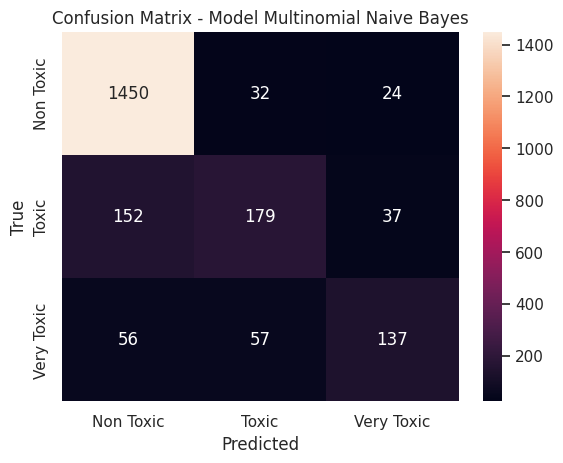

In [ ]:
cf = confusion_matrix (ytest,pred_mnb)
label_name = ['Non Toxic','Toxic','Very Toxic']
sns.set(font_scale=1.)
sns.heatmap(cf, annot=True,xticklabels=label_name,yticklabels=label_name, annot_kws={"size": 12},fmt='d')
plt.title ("Confusion Matrix - Model Multinomial Naive Bayes",fontsize=12)
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('True',fontsize=12)
plt.show()

So sánh độ chính xác của 5 mô hình

In [ ]:
data_accuracy = {
    'SVC': accuracy_score(ytest,pred_svm),
    'Logistic Regress.':accuracy_score(ytest,pred_rgs),
    'Random Forest': accuracy_score(ytest,pred_rdf),
    'Decision Tree': accuracy_score(ytest,pred_tree),
    'MultinomialNB': accuracy_score(ytest,pred_mnb),
}

df = pd.DataFrame.from_dict(data_accuracy, orient='index', columns=['accuracy'])
df = df.reset_index().rename(columns={'index': 'model'})

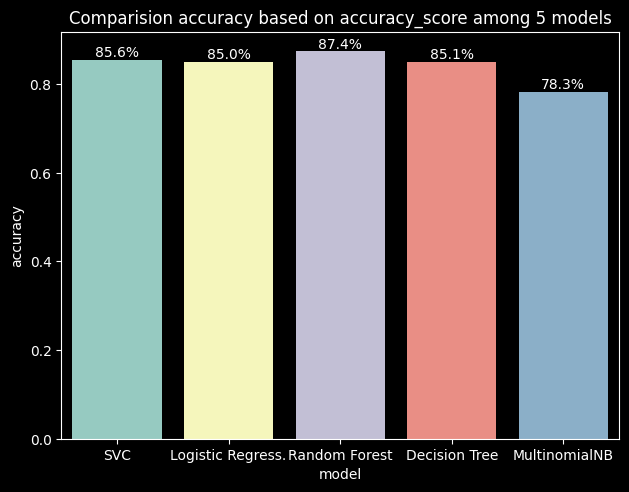

In [ ]:
# Create bar chart
sns.barplot(x='model', y='accuracy', data=df)

# Add labels to bars
ax = plt.gca()
for bar in ax.containers:
    ax.bar_label(bar, label_type='edge', labels=[f"{x:.1%}" for x in bar.datavalues], fontsize=10)

# Adjust the layout
plt.tight_layout()
plt.title ("Comparision accuracy based on accuracy_score among 5 models")
plt.show()

Thống kê các trường hợp dự đoán sai của mô hình có accuracy_score tốt nhất (Logistic Regression)

In [ ]:
sentence_difference = list ()
predict_label = list ()
true_label = list ()

for i in range (len(pred_rdf)):
  if pred_rdf[i] != ytest[i]:
    sentence_difference.append (xtest[i])
    true_label.append (ytest[i])
    predict_label.append (pred_rdf[i])
#print (diff_list)

dict_df = {
    "Sentence": sentence_difference,
    "Predict": predict_label,
    "True": true_label
}

#Print the headline has different predict with true label
df_differ = pd.DataFrame (dict_df)
#Xuất thành file csv
#df_differ.to_csv("/content/differ_in_predict.csv")

df_differ

,Sentence,Predict,True
0,# gânđàm,0,1
1,đại_diện Việt_Nam đánh đầu_bài đái mặt_nước,0,2
2,bây_giờ cảnh 2 slot chung_kết thế_giới wc gõ n...,0,1
3,năng_lực buồn năng_lực buồn mấy cu,0,1
4,mất_dạy content đéo,0,2
...,...,...,...
301,đỗ thành_sơn vãi lồn,2,1
302,tập luơng nhục quốc_gia,0,1
303,súc_vật gam é é é,0,2
304,lối đánh hèn gam hèn,0,1


#PhoBert

In [ ]:
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

##Fine tuning

In [ ]:
class CommentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=30):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Comment']
        label = row['Label']
        return text, label

In [ ]:
class CommentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(CommentClassifier, self).__init__()
        self.bert = phobert#AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

##Load Model

In [ ]:
model = CommentClassifier(n_classes = 3)
model

CommentClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

##Tạo hàm train và val

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [ ]:
def prepare_loaders(df):
    df_train, df_test =  train_test_split(df, test_size = 0.20, random_state = 0, shuffle = True)
    df_train, df_valid = train_test_split(df_train, test_size = 0.125, random_state = 0, shuffle = True)
    train_dataset = CommentDataset(df_train, tokenizer, max_len=30)
    valid_dataset = CommentDataset(df_valid, tokenizer, max_len=30)
    test_dataset = CommentDataset(df_test, tokenizer, max_len=30)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=2)

    return train_loader, valid_loader, test_loader

In [ ]:
best_acc = 0

##Bắt đầu train

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 2
model = model.to(device)

In [ ]:
train_loader, valid_loader,test_loader = prepare_loaders(data)

criterion = nn.CrossEntropyLoss()
    # Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
    # Batchsize: 16, 32
optimizer = AdamW(model.parameters(), lr=2e-5)

lr_scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=len(train_loader)*EPOCHS
        )
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)

    train(model, criterion, optimizer, train_loader)
    val_acc = eval()

    if val_acc > best_acc:
        torch.save(model.state_dict(), 'phobert.pth')
        best_acc = val_acc

Epoch 1/2
------------------------------


KeyboardInterrupt: ignored

##Pred && Eval

In [ ]:
y = []
y_ = []
train_loader, valid_loader,test_loader = prepare_loaders(data)
model.eval()
with torch.no_grad():
        data_loader = test_loader
        for dat in data_loader:
            input_ids = dat['input_ids'].to(device)
            attention_mask = dat['attention_masks'].to(device)
            targets = dat['targets'].to(device)
            for i in targets:
                y.append(i)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)
            for i in pred:
                y_.append(i)

            #loss = criterion(outputs, targets)
            #correct += torch.sum(pred == targets)
            #losses.append(loss.item())

In [ ]:
print(f"Accuracy: {accuracy_score(y,y_)}")
print(classification_report(y,y_))

Accuracy: 0.863487611033193
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1544
           1       0.65      0.72      0.68       372
           2       0.73      0.65      0.69       223

    accuracy                           0.86      2139
   macro avg       0.77      0.77      0.77      2139
weighted avg       0.87      0.86      0.86      2139



In [ ]:
print(f"Accuracy PhoBERT: {accuracy_score(y,y_)}")
print ("Precision:",precision_score(y,y_,average='macro'))
print ("Recall:",recall_score(y,y_,average='macro'))
print ("F1:",f1_score(y,y_,average='macro'))

Accuracy PhoBERT: 0.863487611033193
Precision: 0.7731307326418312
Recall: 0.7663888095659842
F1: 0.7684406537326535


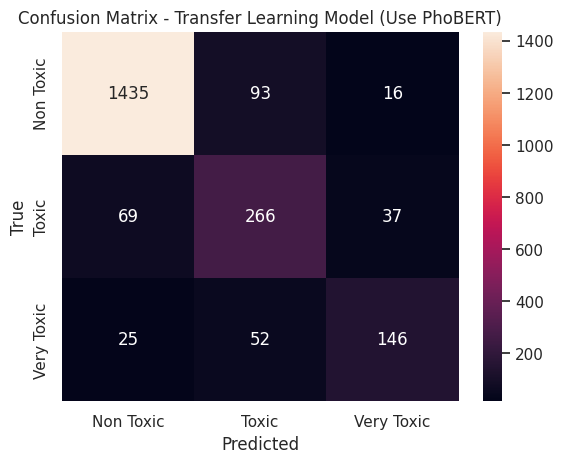

In [ ]:
cf = confusion_matrix (y,y_)
label_name = ['Non Toxic','Toxic','Very Toxic']
sns.set(font_scale=1.)
sns.heatmap(cf, annot=True,xticklabels=label_name,yticklabels=label_name, annot_kws={"size": 12},fmt='d')
plt.title ("Confusion Matrix - Transfer Learning Model (Use PhoBERT)",fontsize=12)
plt.xlabel('Predicted',fontsize=12)
plt.ylabel('True',fontsize=12)
plt.show()

In [ ]:
sentence_difference = list ()
predict_label = list ()
true_label = list ()

for i in range (len(pred_rdf)):
  if pred_rdf[i] != ytest[i]:
    sentence_difference.append (xtest[i])
    true_label.append (ytest[i])
    predict_label.append (pred_rdf[i])
#print (diff_list)

dict_df = {
    "Sentence": sentence_difference,
    "Predict": predict_label,
    "True": true_label
}

#Print the headline has different predict with true label
df_differ = pd.DataFrame (dict_df)
#Xuất thành file csv
#df_differ.to_csv("/content/differ_in_predict.csv")

df_differ

#Load model đã train trước đó

In [ ]:
model = CommentClassifier(n_classes = 3)
model.load_state_dict(torch.load('phobert.pth'))

<All keys matched successfully>

#Lưu model qua drive

In [ ]:
!cp  '/content/drive/MyDrive/CS114/Final_Project/phobert.pth' '/content/phobert.pth'